In [1]:
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from random import random
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
import warnings

In [2]:
class Country():
    def __init__(self, iso, geometry):
        self.iso = iso
        self.geometry = geometry
        self.properties = {}
    def __str__(self):
        return self.iso

In [3]:
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries_on_map = reader.records()

countries = []
for country_on_map in countries_on_map:
    iso = country_on_map.attributes['iso_a3']
    geometry = country_on_map.geometry
    countries.append(Country(iso, geometry))

In [4]:
def plot_map(country_list, property_to_plot, colormap='rainbow', min_value=0, max_value=1):
    def color_country(ax, color, country):
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                            facecolor=color)
    cmap=plt.get_cmap(colormap)

    # hack colorbar
    CS3 = plt.imshow([[min_value, 0], [0, max_value]], cmap=cmap)
    plt.clf()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.axes(projection=cartopy.crs.Robinson())
    ax.add_feature(cartopy.feature.OCEAN)

    missing_countries = []
    for country in countries:
        color = (1,1,1)
        try:
            color = cmap((country.properties[property_to_plot] - min_value)/(max_value - min_value))
        except KeyError as k:
            missing_countries.append(country.iso)
        color_country(ax, color, country)
    print("No property", property_to_plot, "for countries", missing_countries, ".")
    plt.colorbar(CS3, orientation='horizontal', aspect=50)
    plt.show()

In [5]:
temperature_data = pd.read_excel('/home/julian/Code/hpk-symposium/resources/cckp_historical_data_0.xls', 
                                 sheetname='Country_temperatureCRU')
iso = temperature_data['ISO_3DIGIT']
annual_mean_temperature = temperature_data['Annual_temp']
annual_mean_temperature.index = iso.values

In [6]:
def add_country_property(countries, property_name, property_table):
    missing_countries = []
    for country in countries:
        try:
            country.properties[property_name] = property_table[country.iso]
        except KeyError as k:
            missing_countries.append(country.iso)
    print("Don't know these countries:", missing_countries)

In [7]:
add_country_property(countries, 'temperature', annual_mean_temperature)

Don't know these countries: ['ATA', 'ATF', '-99', 'GRL', '-99', 'PSE', '-99', 'TWN']


No property temperature for countries ['ATA', 'ATF', '-99', 'GRL', '-99', 'PSE', '-99', 'TWN'] .


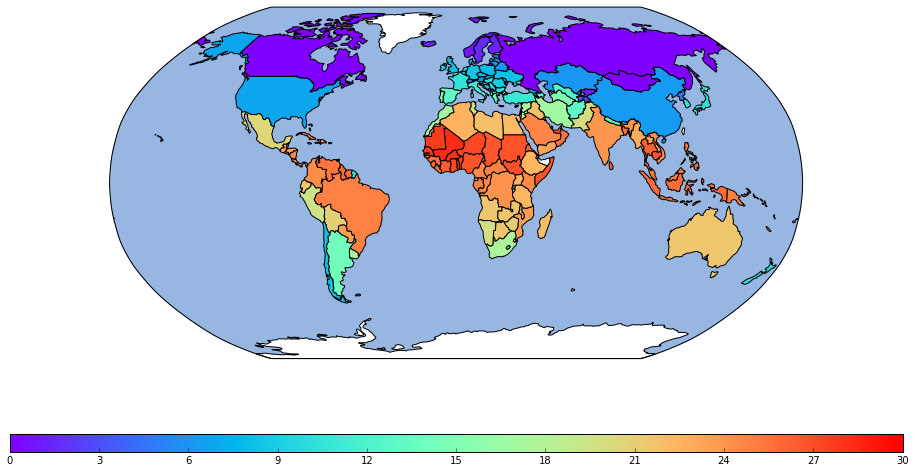

In [8]:
plot_map(countries, 'temperature', 'rainbow', min_value=0, max_value=30)

In [25]:
refugees_origin_data = pd.read_csv('/home/julian/Code/hpk-symposium/resources/sm.pop.refg.or_Indicator_en_csv_v2.csv', header=1)
iso = refugees_origin_data['Country Code']
refugees_origin = refugees_origin_data['2012']

refugees_destination_data = pd.read_csv('/home/julian/Code/hpk-symposium/resources/sm.pop.refg_Indicator_en_csv_v2.csv', header=1)
iso = refugees_destination_data['Country Code']
refugees_destination = refugees_destination_data['2012']

net_refugees = refugees_origin - refugees_destination
net_refugees.index = iso

In [26]:
add_country_property(countries, 'net_refugees', net_refugees)

Don't know these countries: ['ATA', 'ATF', '-99', 'FLK', '-99', 'ESH', '-99', 'TWN']


No property net_refugees for countries ['ATA', 'ATF', '-99', 'FLK', '-99', 'ESH', '-99', 'TWN'] .


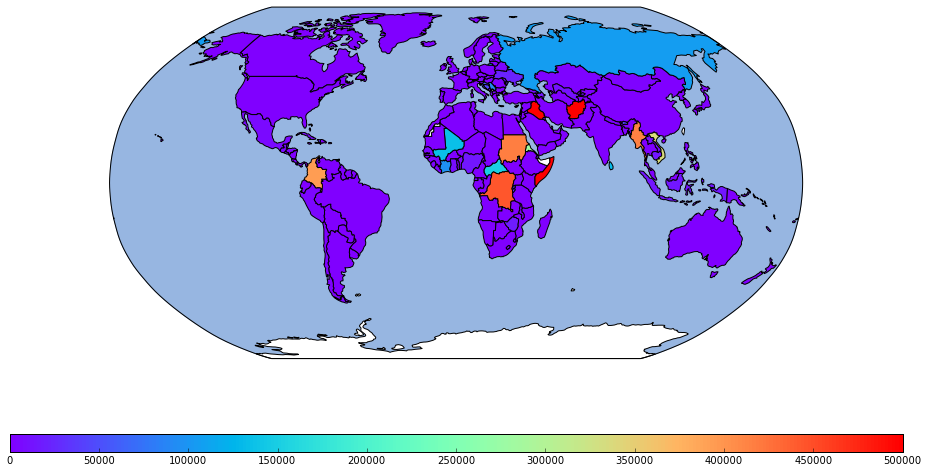

In [27]:
plot_map(countries, 'net_refugees', max_value=.5e+6)

In [9]:
population_data = pd.read_csv('/home/julian/Code/hpk-symposium/resources/sp.pop.totl_Indicator_en_csv_v2.csv', header=2)
iso = population_data['Country Code']
population = population_data['2010']
population.index = iso

In [10]:
add_country_property(countries, 'population', population)

Don't know these countries: ['ATA', 'ATF', '-99', 'FLK', '-99', 'ESH', '-99', 'TWN']


No property population for countries ['ATA', 'ATF', '-99', 'FLK', '-99', 'ESH', '-99', 'TWN'] .


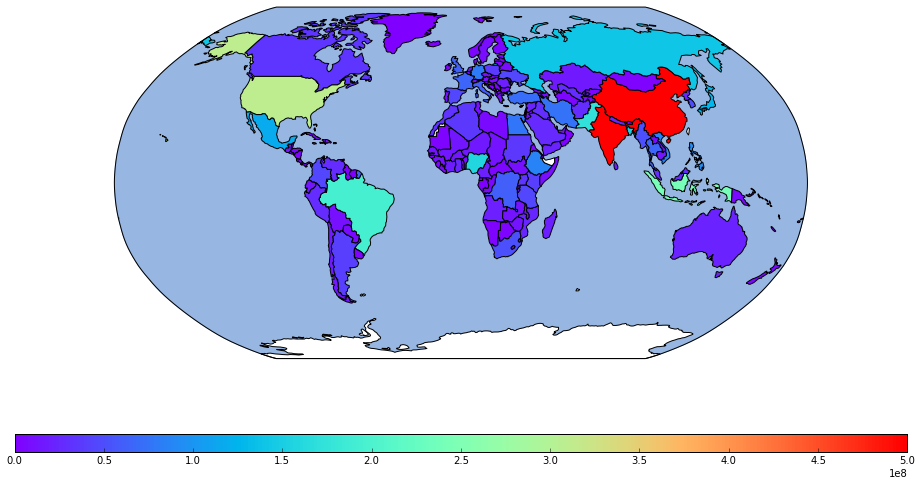

In [11]:
plot_map(countries, 'population', max_value=.5e+9)